# RNSGA-II

RNSGA-II is an advanced, elitist multiobjective evolutionary algorithm that extends NSGA-II by incorporating **reference points** to guide the search toward regions of interest specified by the decision-maker. This modification is introduced in the **survival selection** phase, where the algorithm not only considers Pareto dominance and crowding distance but also evaluates the proximity of each solution to predefined reference points.

## Key Features

- **Fast Nondominated Sorting:**  
  RNSGA-II sorts the population based on Pareto dominance with a computational complexity of  
  $O(MN^2)$, where $M$ is the number of objectives and $N$ is the population size.

- **Elitist Selection with Reference Points:**  
  The algorithm forms a combined pool of parent and offspring populations. From this pool, the best solutions are selected not only based on fitness and diversity but also on their proximity to the reference points. This ensures that solutions closer to the preferred regions have a higher chance of survival.

- **Crowding Distance for Diversity Maintenance:**  
  To maintain a diverse Pareto front, RNSGA-II computes the *crowding distance* for each individual. In addition, it assesses each solution’s distance from the reference points.  

  <div style="text-align: center;">
    <img src="../../images/rnsga2_ref_points.png" alt="RNSGA-II crowding distance illustration" width="600px" />
  </div>
  
  Individuals with a **larger crowding distance** or those nearer to the reference points are favored, thus promoting diversity while also focusing the search in regions of interest.

- **Modified Survival Selection:**  
  The survival selection process in RNSGA-II is enhanced by:
  - **Reference Point Proximity:** Evaluating how close each solution is to the predefined reference points.
  - **Combined Ranking:** First ranking solutions by Pareto dominance, then by crowding distance, and finally giving extra priority to those closer to the reference points.  
    This approach effectively balances convergence toward the Pareto-optimal front with targeted exploration of preferred regions.

- **Constraint Handling:**  
  When constraints_fn are present, feasible solutions are always favored. Among these, solutions with a better (i.e., lower) nondomination rank are preferred, and if ties occur, those with a higher crowding distance and closer to the reference points are selected.

## ZTD1 Problem

The **ZTD1** problem is commonly used as a benchmark problem to evaluate multiobjective optimization algorithms that incorporate reference points. It challenges the algorithm with:

- **Two Conflicting Objectives:**
  - $f_1(\mathbf{x}) = x_1$
  - $f_2(\mathbf{x}) = g(\mathbf{x}) \cdot h(f_1(\mathbf{x}), g(\mathbf{x}))$

- **Auxiliary Functions:**
  - $g(\mathbf{x}) = 1 + \frac{9}{n-1}\sum_{i=2}^{n} x_i$
  - $h(f_1, g) = 1 - \sqrt{\frac{f_1}{g}}$

- **Key Characteristics:**
  - **Continuous and Convex Pareto Front:**  
    Unlike problems with discontinuous fronts, ZTD1 features a continuous and convex Pareto front. This facilitates convergence while still posing a challenge in maintaining solution diversity.
  - **Incorporation of Reference Points:**  
    The use of reference points in RNSGA-II directs the search toward specific regions of the Pareto front, ensuring that the obtained solutions align with the decision-maker’s preferences.

**Domain:**  
Each decision variable $x_i$ is typically within the interval $[0, 1]$, and the problem is commonly defined with $n = 30$ variables.


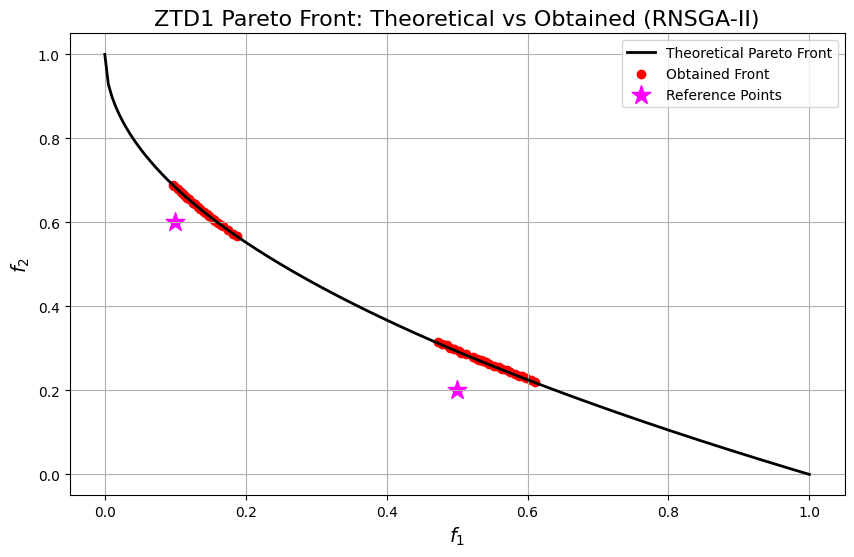

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from pymoors import (
    Rnsga2,
    RandomSamplingFloat,
    GaussianMutation,
    SimulatedBinaryCrossover,
    CloseDuplicatesCleaner,
)
from pymoors.schemas import Population
from pymoors.typing import TwoDArray

np.seterr(invalid="ignore")


def evaluate_ztd1(x: TwoDArray) -> TwoDArray:
    """
    Evaluate the ZTD1 objectives in a fully vectorized manner.
    """
    f1 = x[:, 0]
    g = 1 + 9.0 / (30 - 1) * np.sum(x[:, 1:], axis=1)
    f2 = g * (1 - np.power((f1 / g), 0.5))
    return np.column_stack((f1, f2))


def ztd1_theoretical_front():
    """
    Compute the theoretical Pareto front for ZTD1.
    """
    f1_theo = np.linspace(0, 1, 200)
    f2_theo = 1 - np.sqrt(f1_theo)
    return f1_theo, f2_theo


# Define two reference points (for example, points on the Pareto front)
reference_points = np.array([[0.5, 0.2], [0.1, 0.6]])

# Set up RNSGA-II algorithm with epsilon = 0.01
algorithm = Rnsga2(
    sampler=RandomSamplingFloat(min=0, max=1),
    crossover=SimulatedBinaryCrossover(distribution_index=10),
    mutation=GaussianMutation(gene_mutation_rate=0.1, sigma=0.01),
    fitness=evaluate_ztd1,
    num_objectives=2,
    num_constraints=0,
    duplicates_cleaner=CloseDuplicatesCleaner(epsilon=1e-8),
    num_vars=30,
    population_size=50,
    num_offsprings=50,
    num_iterations=250,
    mutation_rate=0.1,
    crossover_rate=0.9,
    keep_infeasible=False,
    upper_bound=1,
    lower_bound=0,
    reference_points=reference_points,
    verbose=False,
    epsilon=0.005,
    seed=1729,
)

# Run the algorithm
algorithm.run()

# Get the best Pareto front obtained (as a Population instance)
best: Population = algorithm.population.best_as_population
obtained_fitness = best.fitness

# Compute the theoretical Pareto front for ZTD1
f1_theo, f2_theo = ztd1_theoretical_front()

# Plot the theoretical Pareto front, obtained front, and reference points
plt.figure(figsize=(10, 6))
plt.plot(f1_theo, f2_theo, "k-", linewidth=2, label="Theoretical Pareto Front")
plt.scatter(
    obtained_fitness[:, 0],
    obtained_fitness[:, 1],
    c="r",
    marker="o",
    label="Obtained Front",
)
plt.scatter(
    [pt[0] for pt in reference_points],
    [pt[1] for pt in reference_points],
    marker="*",
    s=200,
    color="magenta",
    label="Reference Points",
)
plt.xlabel("$f_1$", fontsize=14)
plt.ylabel("$f_2$", fontsize=14)
plt.title("ZTD1 Pareto Front: Theoretical vs Obtained (RNSGA-II)", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()